# Homework 1 olivettiface 数据集训练

In [55]:
from sklearn.datasets import fetch_olivetti_faces
import torch.nn as nn
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
# 数据下载
olivetti_faces = fetch_olivetti_faces()
print(olivetti_faces.data.shape) # data
print(olivetti_faces.target.shape) # labels
print(olivetti_faces.images.shape) # images

(400, 4096)
(400,)
(400, 64, 64)


In [3]:
print("总计有%s人的图片信息"%len(set(olivetti_faces.target)))

总计有40人的图片信息


In [47]:
# 数据预处理
labels = torch.tensor(olivetti_faces.target,dtype = torch.long)
trainset = torch.tensor(olivetti_faces.data)
dataset = torch.utils.data.TensorDataset(trainset,labels)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=60,shuffle=True)

In [27]:
type(labels)

torch.Tensor

In [53]:
# 搭建模型
class basicModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4096, 1024)  
        self.linear2 = nn.Linear(1024, 256)
        self.linear3 = nn.Linear(256, 40)
        self.relu = nn.ReLU()


    def forward(self, input): # 前向传播
        x = self.linear1(input)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)     
        return x

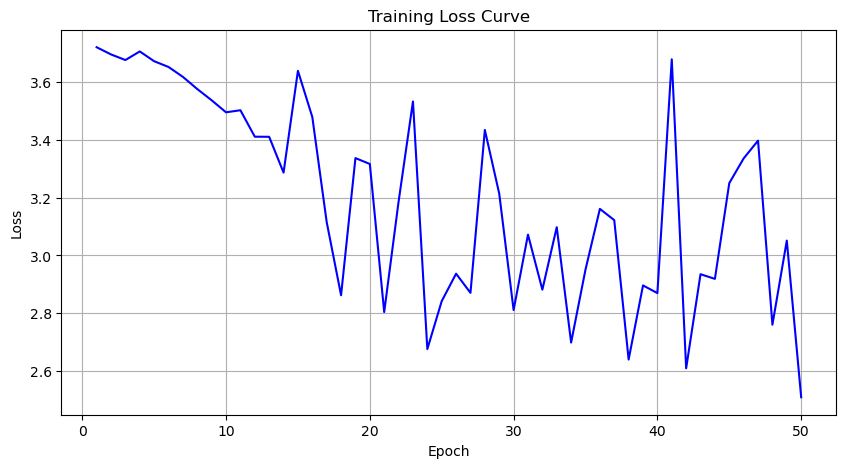

In [56]:
# 参数设置
lr = 0.1
epochs = 50

loss = nn.CrossEntropyLoss()
model = basicModel()
def train_model(dataloader, model, loss, lr, epochs):
    loss_list = []
    for epoch in range(epochs):
        for data, target in dataloader:
            # 前向运算
            output = model(data)
            # 计算损失
            loss_value = loss(output, target)
            # 反向传播
            model.zero_grad()  # 所有参数梯度清零
            loss_value.backward()     # 计算梯度（参数.grad）
            for paras in model.parameters():
                paras.data -= paras.grad * lr
        loss_list.append(loss_value.item())
        # print(f'Epoch:{epoch} Loss: {loss_value.item()}')

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), loss_list, 'b-')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

train_model(dataloader, model, loss, lr, epochs)

# Homework2 结合归一化和正则化来优化网络模型结构

In [ ]:
# 搭建模型
class proModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4096, 1024)
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)    
        self.linear2 = nn.Linear(1024, 256)
        self.linear3 = nn.Linear(256, 40)
        self.relu = nn.ReLU()

    def forward(self, input): # 前向传播
        x = self.linear1(input)
        x = self.batchnorm1(x)
        x = self.dropout1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)     
        return x

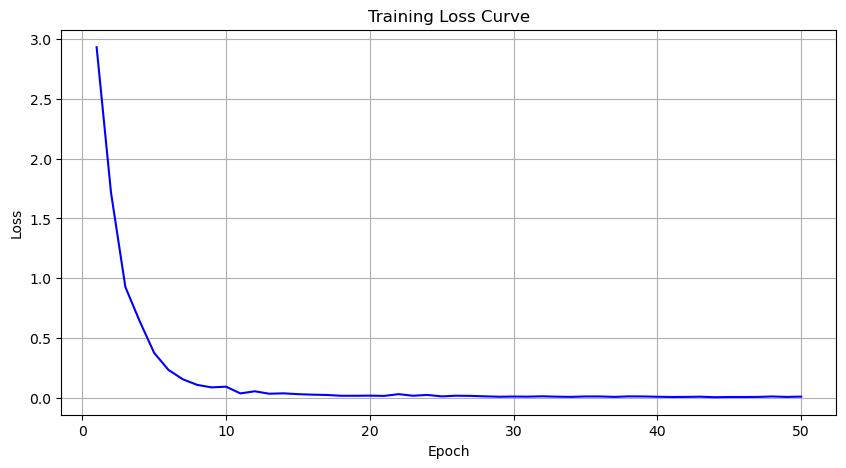

In [ ]:
model = proModel()
train_model(dataloader, model, loss, lr, epochs)
# 损失函数快速下降

# Homework3 尝试不同optimizer对模型进行训练，观察对比loss结果

SGD Epoch 1 Loss: 3.6732
SGD Epoch 2 Loss: 3.3949
SGD Epoch 3 Loss: 3.0088
SGD Epoch 4 Loss: 2.7190
SGD Epoch 5 Loss: 2.3416
SGD Epoch 6 Loss: 1.7962
SGD Epoch 7 Loss: 1.5103
SGD Epoch 8 Loss: 1.0172
SGD Epoch 9 Loss: 0.7947
SGD Epoch 10 Loss: 0.5811
SGD Epoch 11 Loss: 0.3933
SGD Epoch 12 Loss: 0.2866
SGD Epoch 13 Loss: 0.2505
SGD Epoch 14 Loss: 0.1693
SGD Epoch 15 Loss: 0.1741
SGD Epoch 16 Loss: 0.1420
SGD Epoch 17 Loss: 0.1014
SGD Epoch 18 Loss: 0.0687
SGD Epoch 19 Loss: 0.0734
SGD Epoch 20 Loss: 0.0580
RMSprop Epoch 1 Loss: 3.6763
RMSprop Epoch 2 Loss: 2.2925
RMSprop Epoch 3 Loss: 1.3919
RMSprop Epoch 4 Loss: 0.6807
RMSprop Epoch 5 Loss: 0.3881
RMSprop Epoch 6 Loss: 0.1683
RMSprop Epoch 7 Loss: 0.0856
RMSprop Epoch 8 Loss: 0.0697
RMSprop Epoch 9 Loss: 0.1160
RMSprop Epoch 10 Loss: 0.1050
RMSprop Epoch 11 Loss: 0.1442
RMSprop Epoch 12 Loss: 0.1272
RMSprop Epoch 13 Loss: 0.0846
RMSprop Epoch 14 Loss: 0.0216
RMSprop Epoch 15 Loss: 0.0360
RMSprop Epoch 16 Loss: 0.0552
RMSprop Epoch 17 L

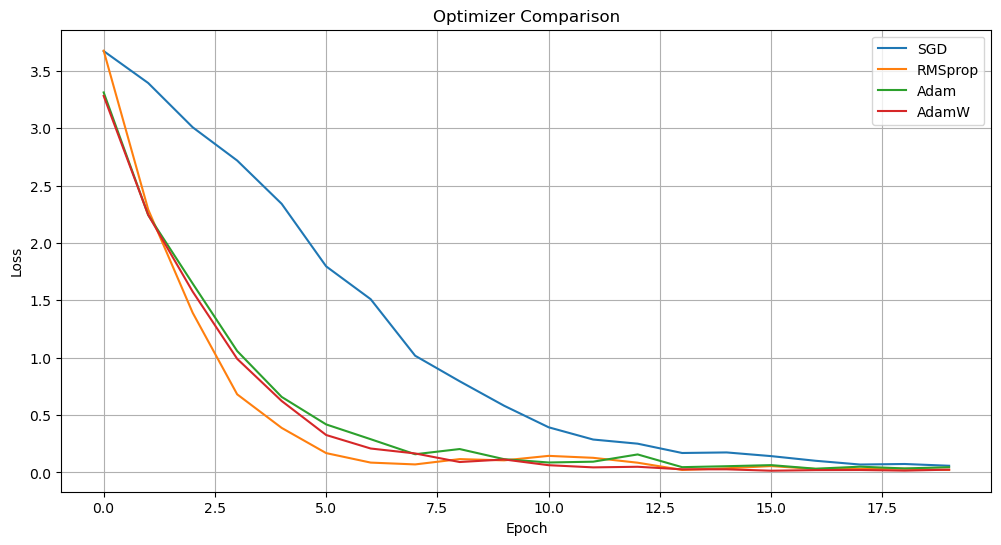

In [61]:
import torch.optim as optim
from copy import deepcopy

# 定义所有优化器配置
optim_configs = {
    'SGD': {'optimizer': optim.SGD, 'args': {'lr': 0.01, 'momentum': 0.9}},
    'RMSprop': {'optimizer': optim.RMSprop, 'args': {'lr': 0.001}},
    'Adam': {'optimizer': optim.Adam, 'args': {'lr': 0.001}},
    'AdamW': {'optimizer': optim.AdamW, 'args': {'lr': 0.001}}
}

# 准备数据加载器
dataset = torch.utils.data.TensorDataset(trainset, labels)
history = {}

for opt_name, config in optim_configs.items():
    # 每次使用新的模型实例
    model = proModel()
    
    # 创建对应数据加载器
    loader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=config.get('batch_size', 128),
        shuffle=True
    )
    
    # 初始化优化器
    optimizer = config['optimizer'](model.parameters(), **config['args'])
    
    # 训练循环
    losses = []
    for epoch in range(20):  # 统一20个epoch
        epoch_loss = 0
        for data, target in loader:
            optimizer.zero_grad()
            output = model(data)
            loss_value = loss(output, target)
            loss_value.backward()
            optimizer.step()
            epoch_loss += loss_value.item()
        
        losses.append(epoch_loss/len(loader))
        print(f"{opt_name} Epoch {epoch+1} Loss: {losses[-1]:.4f}")
    
    history[opt_name] = losses

# 绘制对比曲线
plt.figure(figsize=(12,6))
for opt_name, losses in history.items():
    plt.plot(losses, label=opt_name)

plt.title('Optimizer Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
